In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Data_Cleaner import data_loader_main
import pysindy as psd
from SINDy import SINDy_Train

In [2]:
flow_all, _, occupancy_all, flow_dt, _, occupancy_dt = data_loader_main(csv_dict='Sim_Results/Ramp_MPC')
control_input = pd.read_csv('Results/Meter_Rate_MPCRefine.csv')

In [3]:
# control_input = control_input.iloc[:, 3:]

In [4]:
control_input = control_input/10

In [5]:
# #remove initial 5 seconds
# flow_all = flow_all.iloc[5:,:]
# flow_dt = flow_dt.iloc[5:,:]
# occupancy_all = occupancy_all.iloc[5:,:]
# occupancy_dt = occupancy_dt.iloc[5:,:]
# control_input = control_input.iloc[5:,:]

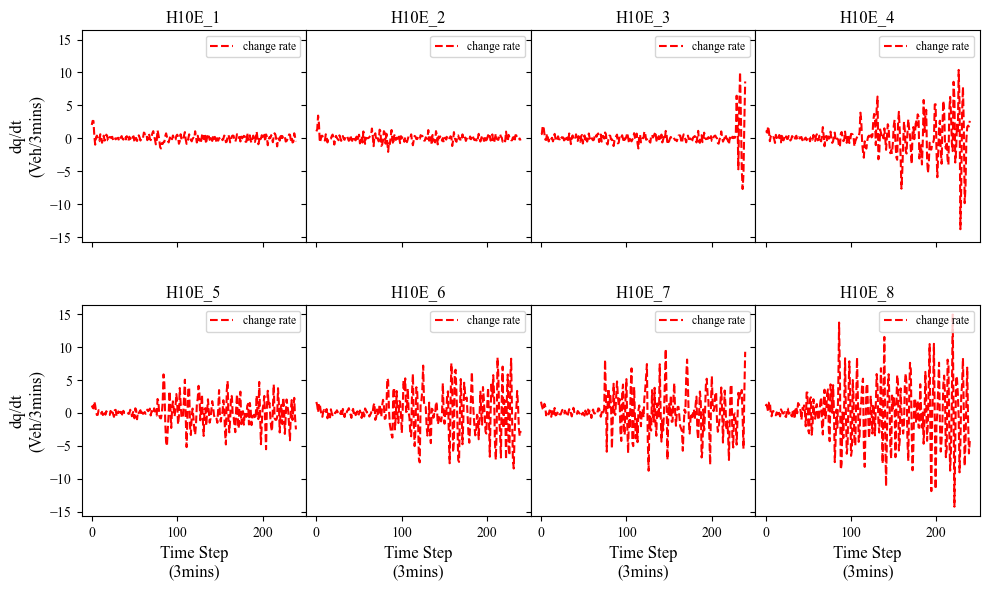

In [6]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(occupancy_dt.iloc[:, index], "--", label = 'change rate', color = "red")
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(occupancy_all.columns[index], fontsize=12)

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.show()
#fig.savefig('Figures/Flow_val.png', dpi=300)

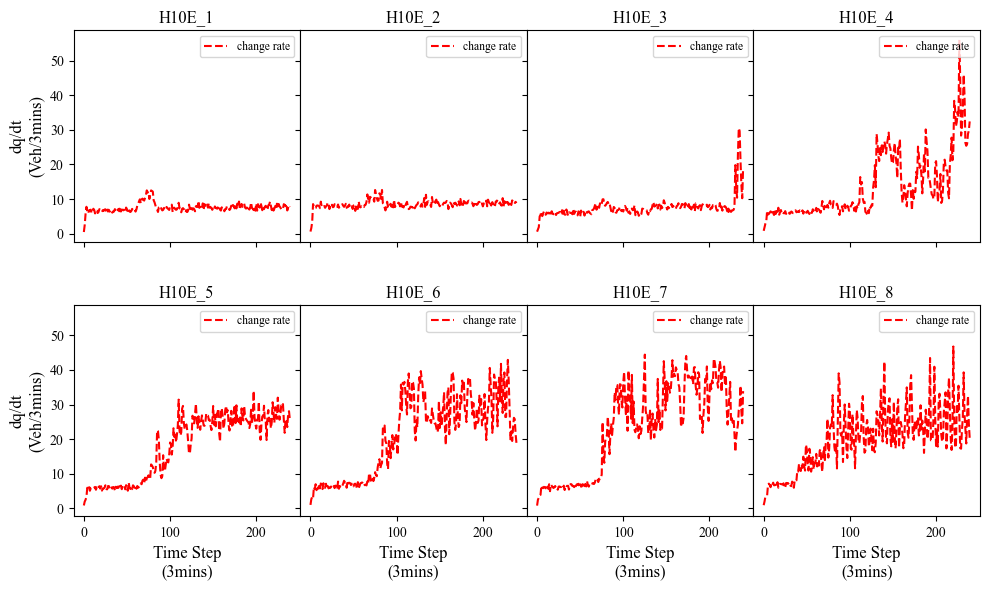

In [7]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(occupancy_all.iloc[:, index], "--", label = 'change rate', color = "red")
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.show()

In [8]:
train_obs = round(flow_all.shape[0]*0.6)

In [9]:
flow_train = flow_all.iloc[:train_obs,:]
flow_dt_train = flow_dt.iloc[:train_obs,:]
flow_val = flow_all.iloc[train_obs:, :]
flow_dt_val = flow_dt.iloc[train_obs:, :]
control_train = control_input.iloc[:train_obs,:]
control_val = control_input.iloc[train_obs:, :]

In [10]:
occupancy_train = occupancy_all.iloc[:train_obs,:]
occupancy_dt_train = occupancy_dt.iloc[:train_obs,:]
occupancy_val = occupancy_all.iloc[train_obs:, :]
occupancy_dt_val = occupancy_dt.iloc[train_obs:, :]

## SINDY

In [19]:
model = SINDy_Train(x = occupancy_train, dx = occupancy_dt_train, u = control_train, threshold= 0.005)

In [20]:
model.print()

(x0)' = 0.050 x0 + 0.323 x1 + -0.957 x2 + -0.499 x3 + 0.433 x4 + -0.405 x5 + 0.136 x6 + 0.077 x7 + 0.119 u0 + 0.042 u1 + -0.107 u2 + -0.046 u5 + 0.006 u6 + 0.009 x0 x1 + -0.014 x0 x3 + -0.013 x0 u0 + 0.012 x0 u2 + -0.049 x1^2 + 0.133 x1 x2 + 0.048 x1 x3 + -0.103 x1 x4 + 0.062 x1 x5 + -0.009 x1 x7 + -0.005 x1 u1 + 0.006 x1 u5 + -0.022 x2^2 + 0.008 x2 x3 + 0.048 x2 x4 + -0.016 x2 x5 + -0.021 x2 x6 + 0.008 x3 x4
(x1)' = 1.016 x0 + -0.737 x1 + -0.137 x4 + -0.006 x5 + 0.007 u2 + -0.068 x0 x1 + -0.011 x0 x2 + 0.034 x1^2 + 0.021 x1 x2 + -0.042 x1 x3 + 0.047 x1 x4 + -0.020 x1 x6 + 0.007 x1 u2 + -0.015 x2^2 + 0.051 x2 x3 + -0.037 x2 x4 + 0.026 x2 x6 + -0.009 x2 u2
(x2)' = -1.768 x1 + 2.367 x2 + -1.149 x3 + 1.111 x4 + -0.504 x5 + 0.091 x6 + -0.067 u0 + 0.122 u2 + -0.055 u3 + -0.048 u4 + 0.057 u6 + 0.037 x0^2 + 0.023 x0 x1 + -0.109 x0 x2 + -0.016 x0 x3 + -0.022 x0 x4 + 0.013 x0 x5 + 0.019 x0 x6 + 0.009 x0 u3 + -0.009 x0 u6 + -0.081 x1^2 + 0.182 x1 x2 + 0.142 x1 x3 + -0.027 x1 x4 + 0.013 x1 x5 + -

In [21]:
# Predict derivatives using the learned model
occupancy_dt_pred = model.predict(occupancy_val, u=control_val)

In [22]:
# theta = np.array(library.transform(pd.concat([flow_val, control_val], axis=1)))
# sindy_coeff = np.transpose(model.coefficients())
# flow_dt_pred_2 = np.matmul(theta, sindy_coeff)

In [23]:
flow_dt_val = flow_dt_val.reset_index(drop=True)
occupancy_dt_val = occupancy_dt_val.reset_index(drop=True)

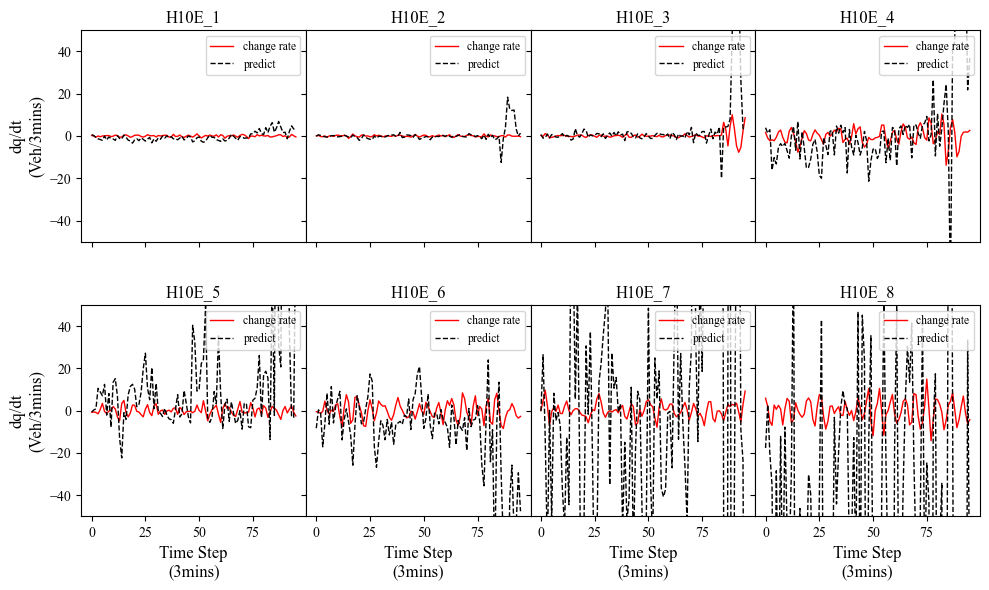

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(occupancy_dt_val.iloc[:, index], "-", label = 'change rate', color = "red",linewidth=1)
        axs[row, col].plot(occupancy_dt_pred[:, index], "--", label = 'predict', color = "black", linewidth=1)
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)
        axs[row, col].set_ylim([-50, 50])

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig('Figures/SINDy_Predict.png', dpi=300)